In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from scipy import sparse 
import warnings
warnings.filterwarnings('ignore')

class OrthogonalMatchingPursuit:
    

    def __init__(self, n_nonzero_coefs=None, tol=1e-4, max_iter=None):
        
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.max_iter = max_iter
        self.coef_ = None
        self.selected_features_ = []
        self.residual_norms_ = []
        self.n_iter_ = 0

    def fit(self, X, y):
       
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples, n_features = X.shape

       
        self.coef_ = np.zeros(n_features)
        residual = y.copy()
        selected_indices = []
        self.residual_norms_ = []

        
        X_normalized = X 

       
        if self.max_iter is None:
            self.max_iter = min(n_samples, n_features)
        if self.n_nonzero_coefs is None:
            self.n_nonzero_coefs = min(n_samples, n_features)

        max_iters = min(self.max_iter, self.n_nonzero_coefs)

        for iteration in range(max_iters):
            
            if residual.ndim > 1:
                correlations = np.abs(X_normalized.T @ residual.flatten())
            else:
                correlations = np.abs(X_normalized.T @ residual)
            
            max_corr_idx = np.argmax(correlations)

            if max_corr_idx not in selected_indices:
                selected_indices.append(max_corr_idx)
            else:
                break

            
            X_selected = X[:, selected_indices]

            try:
                coeffs = np.linalg.lstsq(X_selected, y.flatten(), rcond=None)[0]
                
                self.coef_ = np.zeros(n_features)
                self.coef_[selected_indices] = coeffs
                
                y_pred_current = X_selected @ coeffs
                residual = y.flatten() - y_pred_current 

                residual_norm = np.linalg.norm(residual)
                self.residual_norms_.append(residual_norm)
                
                if residual_norm < self.tol:
                    break
                    
            except np.linalg.LinAlgError:
                print(f"LinAlgError at iteration {iteration}. Breaking.")
                break
            except ValueError as e:
                print(f"ValueError at iteration {iteration}: {e}. Breaking.")
                break
        
        self.selected_features_ = selected_indices
        self.n_iter_ = len(selected_indices)
        
        return self
        
    def predict(self, X):
        
        X = np.asarray(X)
        if self.coef_ is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        return X @ self.coef_

In [2]:

def plot_omp_results_separate(X_train, X_test, y_train, y_test, omp_model, true_coef):
   
    plt.figure(figsize=(10, 6))
    plt.stem(range(len(true_coef)), true_coef, linefmt='g-', markerfmt='go',
                     basefmt=' ', label='True Coefficients')
    plt.stem(range(len(omp_model.coef_)), omp_model.coef_, linefmt='r-',
                     markerfmt='rs', basefmt=' ', label='OMP Coefficients')
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title('True vs Estimated Coefficients')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(range(1, len(omp_model.residual_norms_) + 1),
                         omp_model.residual_norms_, 'b-o', linewidth=2, markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm (log scale)')
    plt.title('OMP Convergence')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
   
    plt.figure(figsize=(10, 6))
    selected_features = omp_model.selected_features_
    if selected_features:
        feature_importance = np.abs(omp_model.coef_[selected_features])
        
        sorted_indices = np.argsort(feature_importance)[::-1]
        sorted_features = np.array(selected_features)[sorted_indices]
        sorted_importance = feature_importance[sorted_indices]

        bars = plt.bar(range(len(sorted_features)), sorted_importance,
                             color='skyblue', edgecolor='navy', alpha=0.7)
        plt.xlabel('Selected Feature (Sorted by Importance)')
        plt.ylabel('|Coefficient Value|')
        plt.title(f'Selected Features ({len(selected_features)} total)')
        plt.xticks(range(len(sorted_features)), [f'F{idx}' for idx in sorted_features], rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        for bar, val in zip(bars, sorted_importance):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                            f'{val:.2f}', ha='center', va='bottom', fontsize=8)
    else:
        plt.text(0.5, 0.5, "No features selected.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Selected Features (None)')
    plt.tight_layout()
    plt.show()
    
    
    y_train_pred = omp_model.predict(X_train)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue', s=30)
    min_val, max_val = min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Training Set Prediction\nR² = {r2_score(y_train, y_train_pred):.3f}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
    y_test_pred = omp_model.predict(X_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='green', s=30)
    min_val, max_val = min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Test Set Prediction\nR² = {r2_score(y_test, y_test_pred):.3f}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
   
    plt.figure(figsize=(8, 7))
    true_active = np.where(true_coef != 0)[0]
    estimated_active = np.array(omp_model.selected_features_)
    
    n_features = len(true_coef)
    true_selected = np.zeros(n_features, dtype=bool)
    true_selected[true_active] = True
    est_selected = np.zeros(n_features, dtype=bool)
    est_selected[estimated_active] = True
    
    tp = np.sum(true_selected & est_selected)  
    fp = np.sum(~true_selected & est_selected)  
    tn = np.sum(~true_selected & ~est_selected)  
    fn = np.sum(true_selected & ~est_selected)  
    
    conf_matrix = np.array([[tn, fp], [fn, tp]])
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Selected', 'Selected'],
                yticklabels=['Not Important', 'Important'],
                cbar=False) 
    plt.title('Feature Selection Confusion Matrix')
    plt.xlabel('Estimated')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    return y_train_pred, y_test_pred

def evaluate_omp_performance(X_train, X_test, y_train, y_test, omp_model, true_coef):
   
    y_train_pred = omp_model.predict(X_train)
    y_test_pred = omp_model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    coef_mse = mean_squared_error(true_coef, omp_model.coef_)
    
    if np.std(true_coef) == 0 or np.std(omp_model.coef_) == 0:
        coef_correlation = np.nan 
    else:
        coef_correlation = np.corrcoef(true_coef, omp_model.coef_)[0, 1]
    
    true_active = set(np.where(true_coef != 0)[0])
    estimated_active = set(omp_model.selected_features_)
    
    precision = len(true_active & estimated_active) / len(estimated_active) if estimated_active else (1 if not true_active else 0)
    recall = len(true_active & estimated_active) / len(true_active) if true_active else (1 if not estimated_active else 0)
    
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    
    true_sparsity = np.sum(true_coef != 0) / len(true_coef)
    estimated_sparsity = np.sum(omp_model.coef_ != 0) / len(omp_model.coef_)
    
    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'coef_mse': coef_mse,
        'coef_correlation': coef_correlation,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_sparsity': true_sparsity,
        'estimated_sparsity': estimated_sparsity,
        'n_iterations': omp_model.n_iter_
    }

def create_dataset_info_plots(X, y, true_coef):
    
    plt.figure(figsize=(10, 8))
    n_features_to_show = min(20, X.shape[1])
    corr_matrix = np.corrcoef(X[:, :n_features_to_show].T)
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".2f", linewidths=.5)
    plt.title(f'Feature Correlations (First {n_features_to_show} features)')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Target Value')
    plt.ylabel('Frequency')
    plt.title('Target Distribution')
    plt.axvline(np.mean(y), color='red', linestyle='--',
                             label=f'Mean: {np.mean(y):.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    if true_coef is not None and np.sum(true_coef) != 0: 
        plt.figure(figsize=(10, 6))
        plt.stem(range(len(true_coef)), true_coef, linefmt='g-',
                         markerfmt='go', basefmt=' ')
        plt.xlabel('Feature Index')
        plt.ylabel('True Coefficient Value')
        plt.title('True Sparse Coefficients')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping 'True coefficient distribution' plot: true_coef is not available or all zeros for external dataset.")
    
    plt.figure(figsize=(8, 6))
    feature_means = np.mean(X, axis=0)
    feature_stds = np.std(X, axis=0)
    
    plt.scatter(feature_means, feature_stds, alpha=0.6, color='purple')
    plt.xlabel('Feature Mean')
    plt.ylabel('Feature Standard Deviation')
    plt.title('Feature Statistics')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [3]:

print("ORTHOGONAL MATCHING PURSUIT (OMP) IMPLEMENTATION")


print("\n1. Loading dataset from CSV...")

DATA_PATH = "/kaggle/input/project02/omp_dataset.csv" 

try:
    df = pd.read_csv(DATA_PATH)
    print(f'Dataset loaded from ["{DATA_PATH}"]. Shape: {df.shape}')
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: Dataset not found at {DATA_PATH}.")
    raise FileNotFoundError(f" '{DATA_PATH}' ")

target_column_name = 'target' 

if target_column_name not in df.columns:
    print(f"Error: Target column '{target_column_name}' not found in the dataset.")
    print(f"Available columns: {df.columns.tolist()}")
    raise ValueError(f"Target column '{target_column_name}' not found.")

y = df[target_column_name].values
X_df = df.drop(columns=[target_column_name])
X = X_df.values


true_coef = np.zeros(X.shape[1]) 

print(f"  Features shape: {X.shape}")
print(f"  Target shape: {y.shape}")

print("\n2. Splitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"  Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"  Testing data shape: X={X_test.shape}, y={y_test.shape}")

print("\n3. Standardizing features (X)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("  Features scaled successfully.")

ORTHOGONAL MATCHING PURSUIT (OMP) IMPLEMENTATION

1. Loading dataset from CSV...
Dataset loaded from ["/kaggle/input/project02/omp_dataset.csv"]. Shape: (200, 51)
First 5 rows of the dataset:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.496714  -0.138264   0.647689   1.523030  -0.234153  -0.234137   
1   0.324084  -0.385082  -0.676922   0.611676   1.031000   0.931280   
2  -1.415371  -0.420645  -0.342715  -0.802277  -0.161286   0.404051   
3   0.250493   0.346448  -0.680025   0.232254   0.293072  -0.714351   
4   0.357787   0.560785   1.083051   1.053802  -1.377669  -0.937825   

   feature_6  feature_7  feature_8  feature_9  ...  feature_41  feature_42  \
0   1.579213   0.767435  -0.469474   0.542560  ...    0.171368   -0.115648   
1  -0.839218  -0.309212   0.331263   0.975545  ...    0.968645   -0.702053   
2   1.886186   0.174578   0.257550  -0.074446  ...    1.307143   -1.607483   
3   1.865775   0.473833  -1.191303   0.656554  ...    0.856399    0.2

In [4]:

print("\n4. Training OMP model...")
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10, tol=1e-6) 
omp.fit(X_train_scaled, y_train)

print(f"  Number of iterations: {omp.n_iter_}")
print(f"  Number of selected features: {len(omp.selected_features_)}")
print(f"  Selected features (first 10): {omp.selected_features_[:10]}...") 

print("\n5. Evaluating OMP performance...")
metrics = evaluate_omp_performance(X_train_scaled, X_test_scaled, y_train, y_test, omp, true_coef) 
print("\n  PREDICTION PERFORMANCE:")
print(f"  Training R²: {metrics['train_r2']:.4f}")
print(f"  Test R²: {metrics['test_r2']:.4f}")
print(f"  Training MSE: {metrics['train_mse']:.4f}")
print(f"  Test MSE: {metrics['test_mse']:.4f}")

print("\n  COEFFICIENT RECOVERY (Note: 'True Coefficients' are estimated if not provided):")
print(f"  Coefficient MSE: {metrics['coef_mse']:.4f}")
print(f"  Coefficient Correlation: {metrics['coef_correlation']:.4f}")

print("\n  FEATURE SELECTION (Based on 'True Coefficients' if available, otherwise limited use):")
print(f"  Precision: {metrics['precision']:.4f}")
print(f"  Recall: {metrics['recall']:.4f}")
print(f"  F1-Score: {metrics['f1_score']:.4f}")

print("\n  SPARSITY:")
print(f"  True sparsity: {metrics['true_sparsity']:.4f}")
print(f"  Estimated sparsity: {metrics['estimated_sparsity']:.4f}")


4. Training OMP model...
  Number of iterations: 10
  Number of selected features: 10
  Selected features (first 10): [23, 0, 15, 4, 19, 10, 44, 17, 34, 42]...

5. Evaluating OMP performance...

  PREDICTION PERFORMANCE:
  Training R²: 0.9982
  Test R²: 0.9981
  Training MSE: 0.1340
  Test MSE: 0.1467

  COEFFICIENT RECOVERY (Note: 'True Coefficients' are estimated if not provided):
  Coefficient MSE: 1.4844
  Coefficient Correlation: nan

  FEATURE SELECTION (Based on 'True Coefficients' if available, otherwise limited use):
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

  SPARSITY:
  True sparsity: 0.0000
  Estimated sparsity: 0.2000



6. Creating dataset characteristics visualizations...


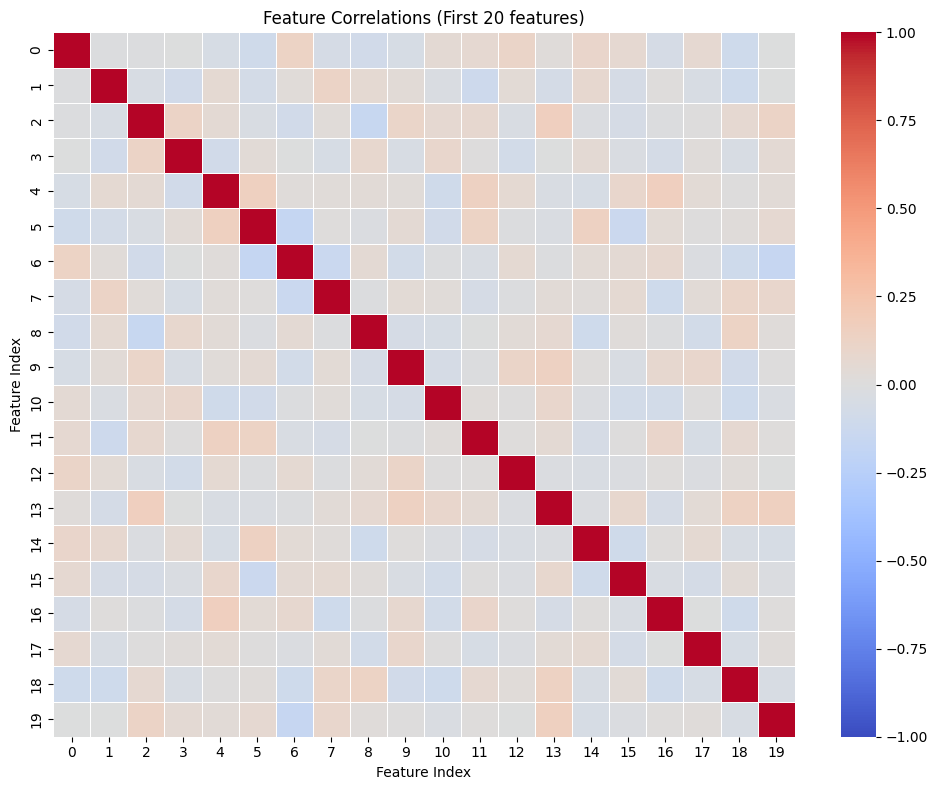

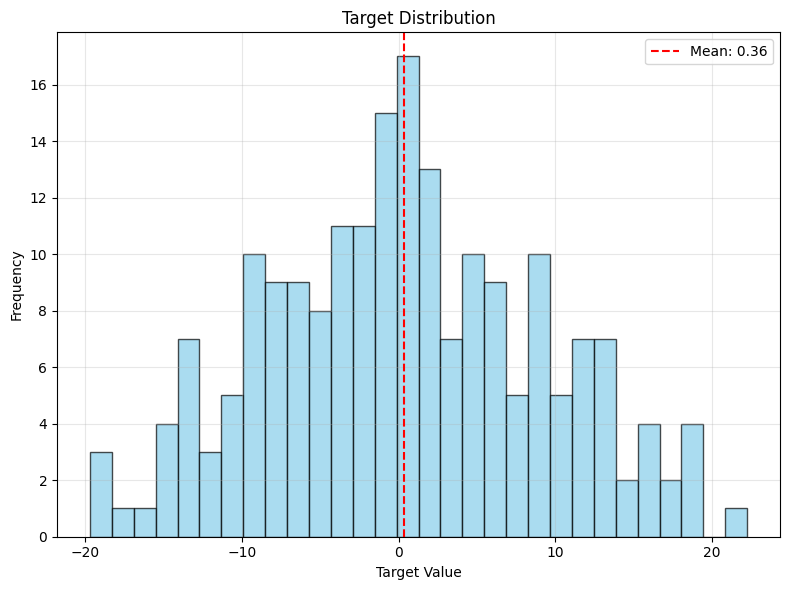

Skipping 'True coefficient distribution' plot: true_coef is not available or all zeros for external dataset.


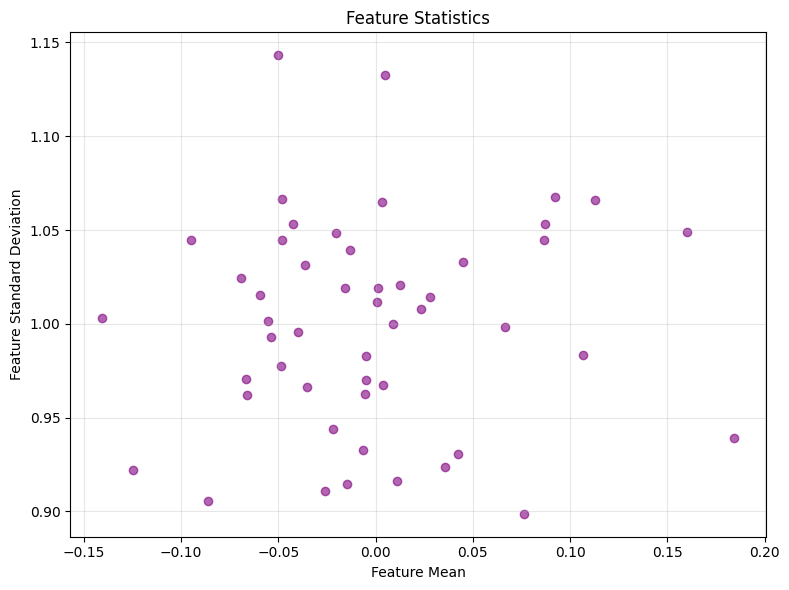

In [5]:

print("\n6. Creating dataset characteristics visualizations...")
create_dataset_info_plots(X, y, true_coef)


7. Creating OMP results visualizations...


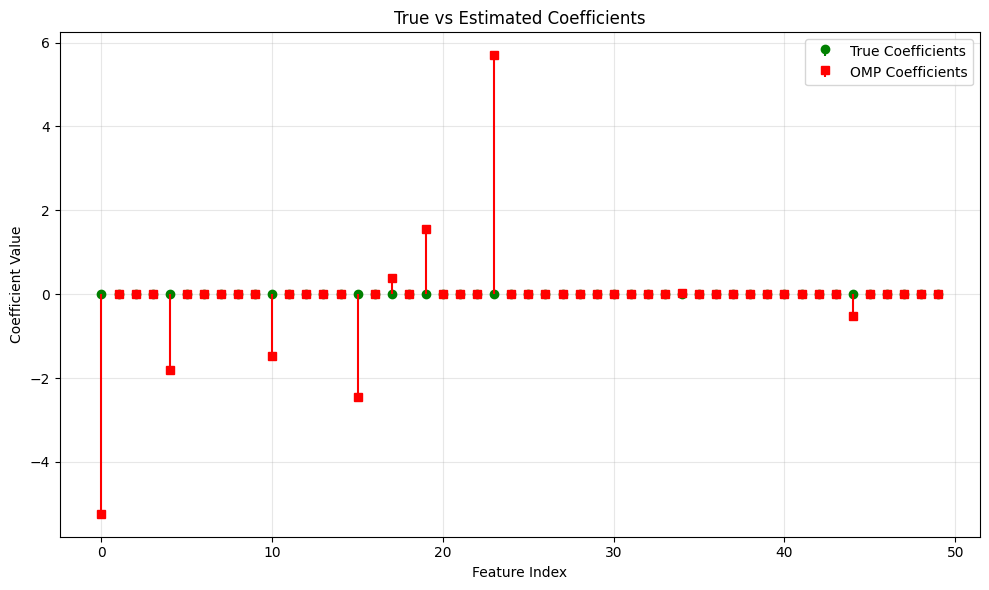

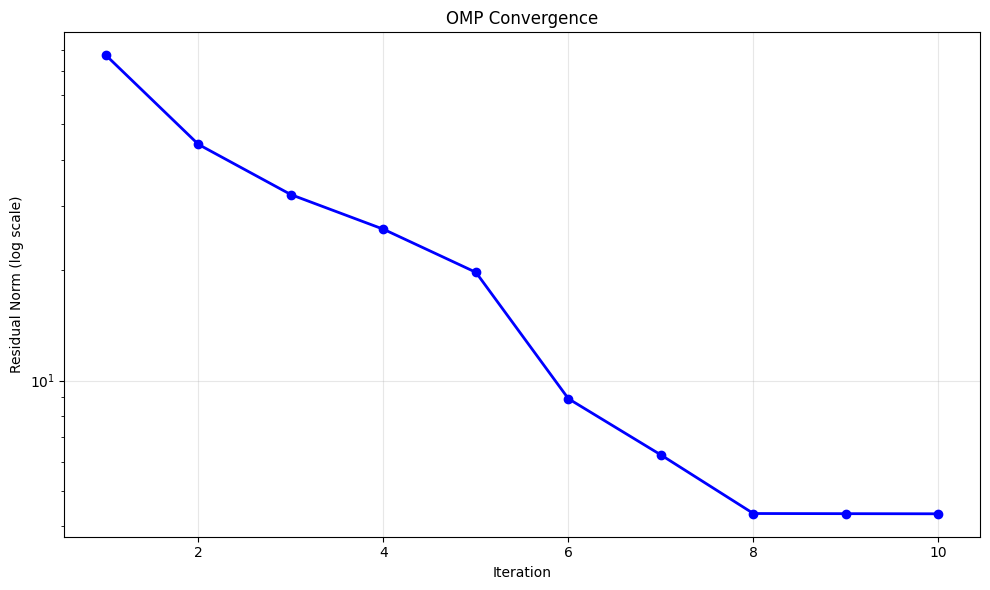

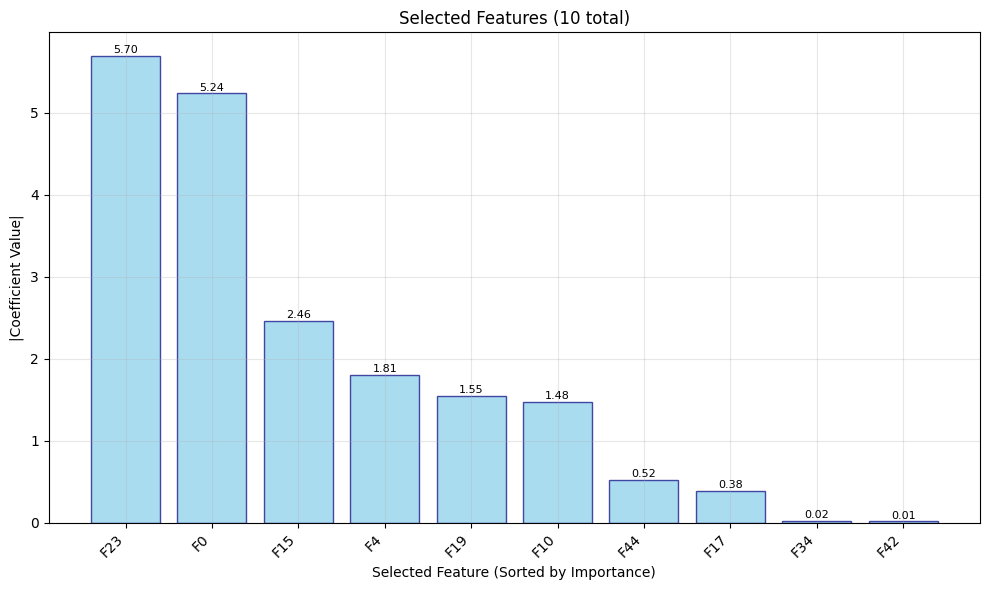

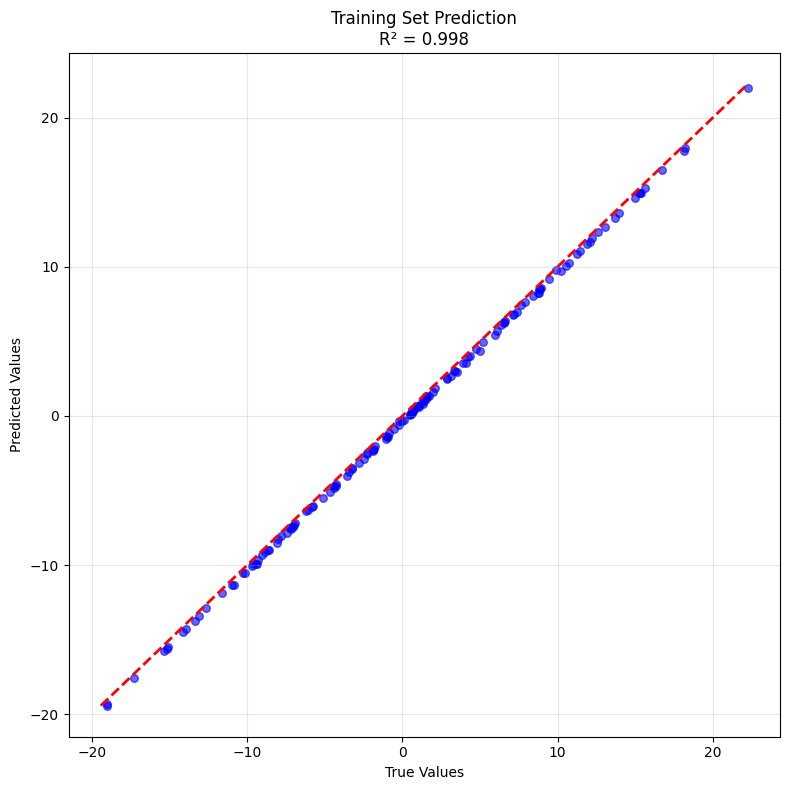

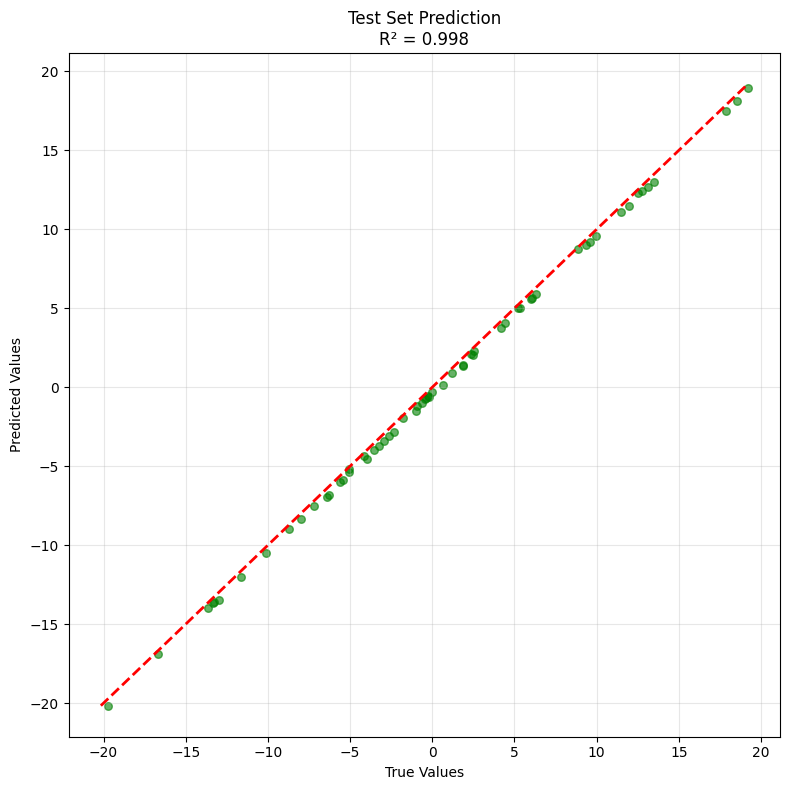

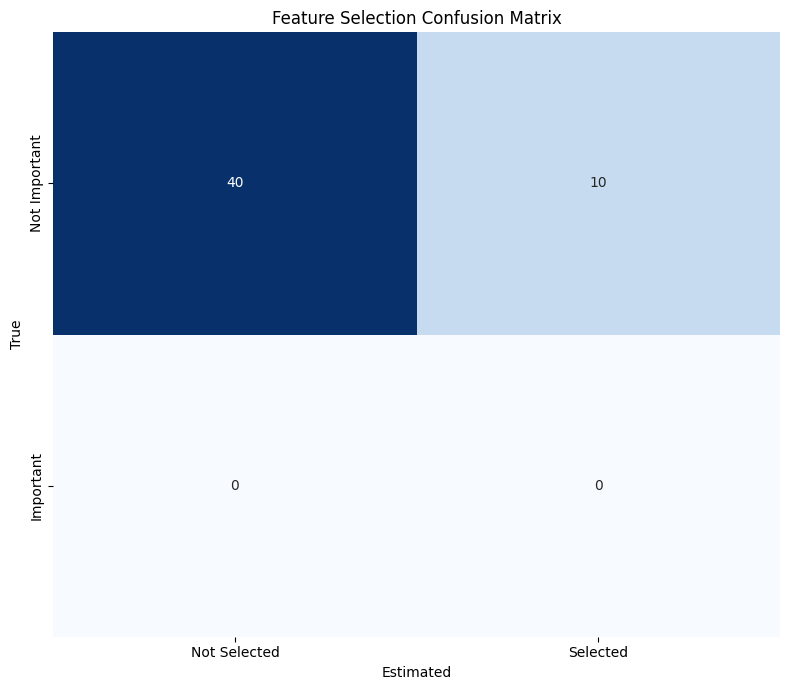

In [6]:
# Cell 6: OMP Results Plots (Separated)

print("\n7. Creating OMP results visualizations...")
y_train_pred, y_test_pred = plot_omp_results_separate(X_train_scaled, X_test_scaled,
                                                      y_train, y_test, omp, true_coef)


8. Comparing OMP performance with different sparsity levels...
  Training OMP with n_nonzero_coefs=5...
  Training OMP with n_nonzero_coefs=10...
  Training OMP with n_nonzero_coefs=15...
  Training OMP with n_nonzero_coefs=20...
  Training OMP with n_nonzero_coefs=25...
  Training OMP with n_nonzero_coefs=30...


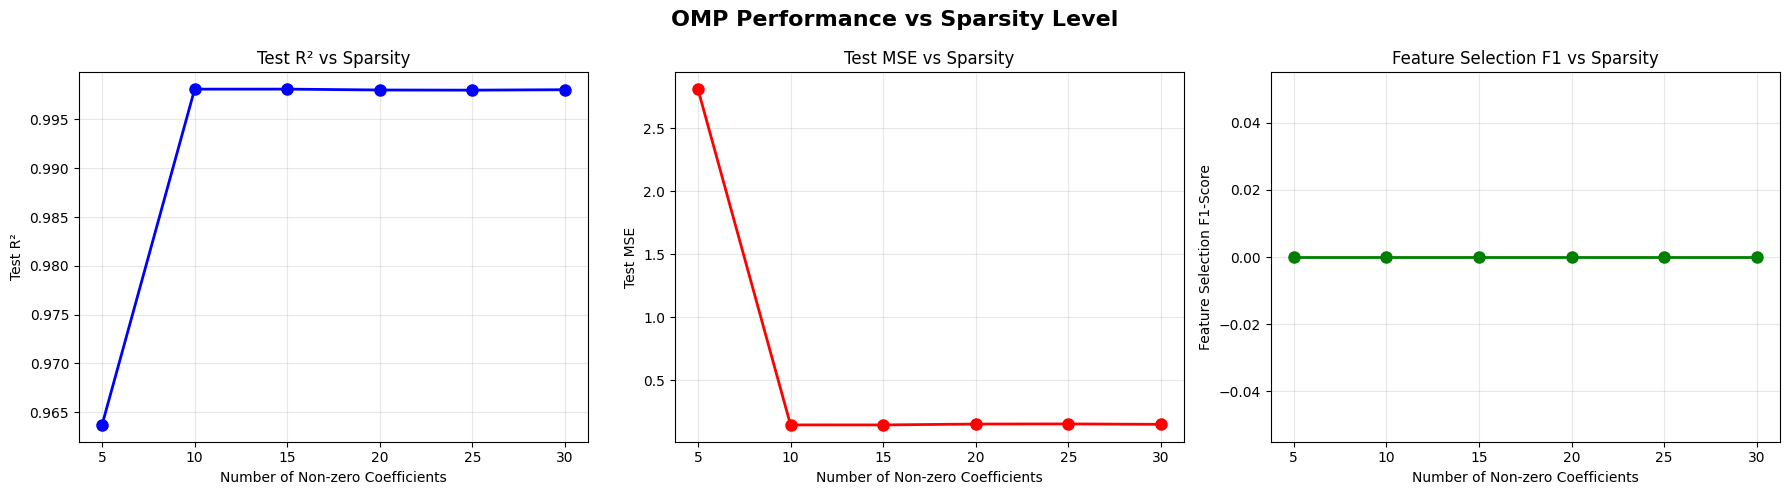

In [7]:

print("\n8. Comparing OMP performance with different sparsity levels...")
sparsity_levels = [5, 10, 15, 20, 25, 30] 
results = []

for n_coef in sparsity_levels:
    print(f"  Training OMP with n_nonzero_coefs={n_coef}...")
    omp_temp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_coef, tol=1e-6)
    omp_temp.fit(X_train_scaled, y_train)
    metrics_temp = evaluate_omp_performance(X_train_scaled, X_test_scaled,
                                           y_train, y_test, omp_temp, true_coef)
    results.append({
        'n_coef': n_coef,
        'test_r2': metrics_temp['test_r2'],
        'test_mse': metrics_temp['test_mse'],
        'f1_score': metrics_temp['f1_score']
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(18, 5))
plt.suptitle('OMP Performance vs Sparsity Level', fontsize=16, fontweight='bold')

plt.subplot(1, 3, 1)
plt.plot(results_df['n_coef'], results_df['test_r2'], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Non-zero Coefficients')
plt.ylabel('Test R²')
plt.title('Test R² vs Sparsity')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(results_df['n_coef'], results_df['test_mse'], 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Non-zero Coefficients')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Sparsity')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(results_df['n_coef'], results_df['f1_score'], 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Non-zero Coefficients')
plt.ylabel('Feature Selection F1-Score')
plt.title('Feature Selection F1 vs Sparsity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
print("\n9. Saving results (optional)...")
processed_df = pd.DataFrame(X_train_scaled, columns=[f'scaled_feature_{i}' for i in range(X_train_scaled.shape[1])])
processed_df['target'] = y_train
processed_df.to_csv('omp_processed_train_data.csv', index=False)

coef_df = pd.DataFrame({
    'feature_index': range(len(omp.coef_)),
    'omp_coefficient': omp.coef_,
    'selected': [i in omp.selected_features_ for i in range(len(omp.coef_))]
})
if true_coef is not None and len(true_coef) == len(omp.coef_):
    coef_df['true_coefficient'] = true_coef
coef_df.to_csv('omp_estimated_coefficients.csv', index=False)

print("  Processed training data saved to 'omp_processed_train_data.csv'")
print("  Estimated coefficients saved to 'omp_estimated_coefficients.csv'")
print("ANALYSIS COMPLETE!")


9. Saving results (optional)...
  Processed training data saved to 'omp_processed_train_data.csv'
  Estimated coefficients saved to 'omp_estimated_coefficients.csv'
ANALYSIS COMPLETE!
